In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For preparation data
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# For modeling data
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense

# For evaluate model
from sklearn.metrics import classification_report

# For sav model
import pickle

In [ ]:
# Download dan extract dataset

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gl9vkLEqldvG9fS4rzYFxZ1nbW8oVtPS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Gl9vkLEqldvG9fS4rzYFxZ1nbW8oVtPS" -O loan_data_2007_2014.csv && rm -rf /tmp/cookies.txt

--2023-05-17 14:36:26--  https://docs.google.com/uc?export=download&confirm=t&id=1Gl9vkLEqldvG9fS4rzYFxZ1nbW8oVtPS
Resolving docs.google.com (docs.google.com)... 108.177.119.102, 108.177.119.113, 108.177.119.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gij6r59d8amojbiap2o7qpjuvvjah1l7/1684334175000/11309364930090306574/*/1Gl9vkLEqldvG9fS4rzYFxZ1nbW8oVtPS?e=download&uuid=8ddaf0b0-60e7-4f11-82a3-6dd9fdc2a843 [following]
--2023-05-17 14:36:26--  https://doc-0k-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gij6r59d8amojbiap2o7qpjuvvjah1l7/1684334175000/11309364930090306574/*/1Gl9vkLEqldvG9fS4rzYFxZ1nbW8oVtPS?e=download&uuid=8ddaf0b0-60e7-4f11-82a3-6dd9fdc2a843
Resolving doc-0k-90-docs.googleusercontent.com (doc-0k-90-docs.googleusercontent.com)... 108.177.127.

In [ ]:
df = pd.read_csv('loan_data_2007_2014.csv',delimiter=',')
df.info()

<ipython-input-3-d3fcec0305f8>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('loan_data_2007_2014.csv',delimiter=',')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [ ]:
# Drop column have > 75% missing values
df_null = df.isnull().mean()
column_drop = list(df_null[df_null > 0.40].index)
column_drop.extend(['Unnamed: 0', 'id', 'member_id']) # add unnecessary column
df.drop(columns=column_drop, inplace=True, axis=1)

# Drop all missing values
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372162 entries, 42535 to 466283
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   372162 non-null  int64  
 1   funded_amnt                 372162 non-null  int64  
 2   funded_amnt_inv             372162 non-null  float64
 3   term                        372162 non-null  object 
 4   int_rate                    372162 non-null  float64
 5   installment                 372162 non-null  float64
 6   grade                       372162 non-null  object 
 7   sub_grade                   372162 non-null  object 
 8   emp_title                   372162 non-null  object 
 9   emp_length                  372162 non-null  object 
 10  home_ownership              372162 non-null  object 
 11  annual_inc                  372162 non-null  float64
 12  verification_status         372162 non-null  object 
 13  issue_d   

In [ ]:
# Build function convert column to date
def convert_date(df, column):
    today_date = pd.to_datetime('2022-07-01')
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['months_since_' + column] = round(pd.to_numeric((today_date - df[column]) /
							np.timedelta64(1, 'M')))
    df['months_since_' + column] = df['months_since_' + column].apply(
		lambda x: df['months_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)

# Creating instance of label encoder
le = LabelEncoder()

In [ ]:
# Drop columns that only have one value
column_one_value = []
for i in df.columns :
    count_unique = len(df[i].unique())
    if count_unique == 1 :
        column_one_value.append(i)
df.drop(columns = column_one_value, inplace = True)

In [ ]:
# Convert variables that have object type to right type

# Convert column term
df['term'] = pd.to_numeric(df['term'].str.replace(' months',''))

# Convert column emp_length
df['emp_length'] = df['emp_length'].str.replace('\+ years','')
df['emp_length'] = df['emp_length'].str.replace('< 1 year',str(0))
df['emp_length'] = df['emp_length'].str.replace(' years','')
df['emp_length'] = df['emp_length'].str.replace(' year','')
df['emp_length'] = pd.to_numeric(df['emp_length'])
df['emp_length'].fillna(0,inplace=True)

# Convert date columns
convert_date(df, 'earliest_cr_line')
convert_date(df, 'issue_d')
convert_date(df, 'last_pymnt_d')
convert_date(df, 'last_credit_pull_d')

# Convert category columns with Label Encoder
category_df = df.select_dtypes(include=['object']).copy()
category_df.drop(columns = ['loan_status'], inplace = True) # Drop Feature Target
for i in category_df.columns.values:
  df[i] = le.fit_transform(df[i])

<ipython-input-8-47510680117e>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['emp_length'] = df['emp_length'].str.replace('\+ years','')


<ipython-input-9-36e83db8a05a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, annot_kws={'size':9})


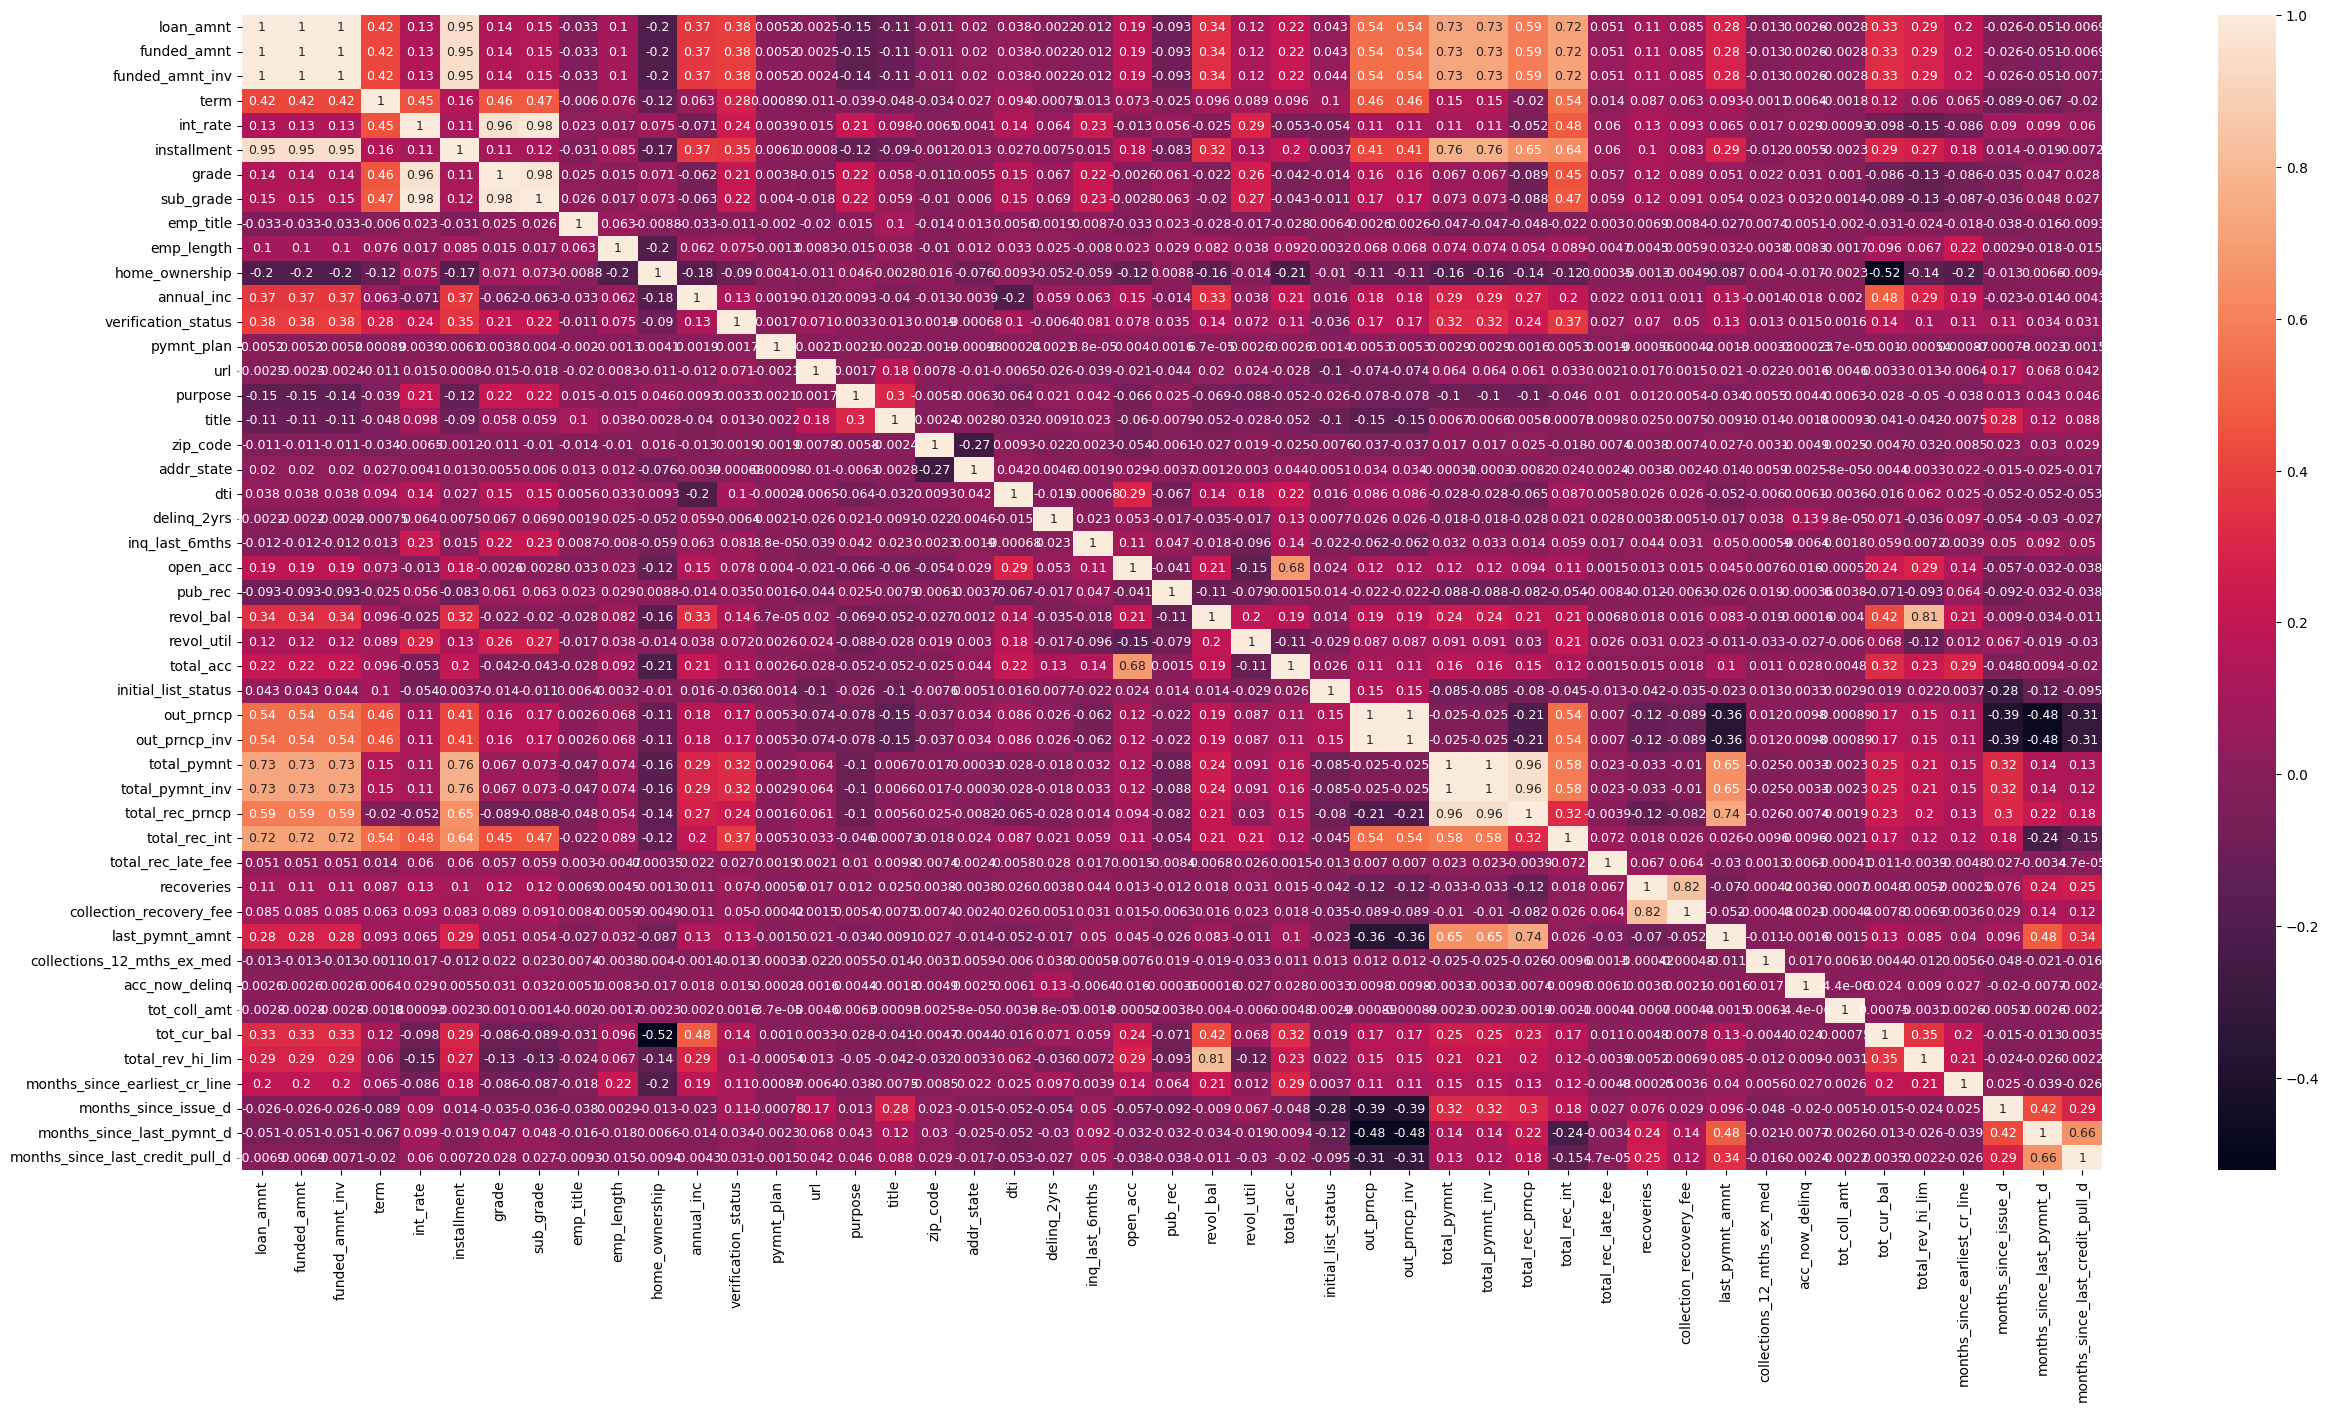

In [ ]:
# To show correlation for each columns
plt.figure(figsize=(30,15))
sns.heatmap(df.corr(), annot=True, annot_kws={'size':9})
plt.show()

In [ ]:
# To show describe statistic
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,months_since_earliest_cr_line,months_since_issue_d,months_since_last_pymnt_d,months_since_last_credit_pull_d
count,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,372162.000000,...,372162.000000,372162.000000,372162.000000,3.721620e+05,3.721620e+05,3.721620e+05,372162.000000,372162.000000,372162.000000,372162.000000
mean,14870.167561,14870.152178,14863.625574,42.948845,14.037092,448.202984,1.850517,11.227358,84878.619478,6.124986,...,3231.643216,0.010670,0.004726,1.892085e+02,1.408846e+05,3.049341e+04,293.686701,101.380651,82.898294,80.089026
std,8299.841479,8299.841773,8296.576525,10.885134,4.382131,243.192512,1.304928,6.460095,47581.951602,3.621079,...,5742.582307,0.117871,0.074700,1.508283e+04,1.526474e+05,3.745919e+04,84.261759,7.418221,7.455966,5.184900
min,1000.000000,1000.000000,950.000000,36.000000,6.000000,23.260000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+02,128.000000,91.000000,78.000000,78.000000
25%,8500.000000,8500.000000,8500.000000,36.000000,10.990000,272.960000,1.000000,6.000000,43349.000000,3.000000,...,323.605000,0.000000,0.000000,0.000000e+00,2.966200e+04,1.370000e+04,237.000000,95.000000,78.000000,78.000000
50%,13200.000000,13200.000000,13200.000000,36.000000,13.980000,395.670000,2.000000,11.000000,88441.000000,7.000000,...,549.860000,0.000000,0.000000,0.000000e+00,8.472850e+04,2.300000e+04,277.000000,100.000000,79.000000,78.000000
75%,20000.000000,20000.000000,20000.000000,60.000000,16.990000,584.910000,3.000000,15.000000,125136.750000,10.000000,...,3279.387500,0.000000,0.000000,0.000000e+00,2.117868e+05,3.810000e+04,337.000000,107.000000,86.000000,78.000000
max,35000.000000,35000.000000,35000.000000,60.000000,26.060000,1409.990000,6.000000,34.000000,166065.000000,10.000000,...,36234.440000,20.000000,5.000000,9.152545e+06,8.000078e+06,9.999999e+06,642.000000,119.000000,118.000000,119.000000


In [ ]:
# Check value in loan_status
df['loan_status'].value_counts()

Current               206686
Fully Paid            124593
Charged Off            29764
Late (31-120 days)      6308
In Grace Period         2949
Late (16-30 days)       1103
Default                  759
Name: loan_status, dtype: int64

In [ ]:
# Classify value loan_status to good and bad borrower and make new column
df['borrower_status'] = np.where(df.loc[:, 'loan_status'].isin([
                                                                'Charged Off',
                                                                'Default',
                                                                'Late (31-120 days)'
                                                                ]),0,1) # 0:bad, 1:good

# Drop loan_status
df.drop(columns=['loan_status'], inplace=True)

In [ ]:
# Check distribution of borrower_status
df['borrower_status'].value_counts()

1    335331
0     36831
Name: borrower_status, dtype: int64

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# the data have unbalanced sample, then it needs class weight to be used in the model
counts = np.bincount(y)
weights_for_0 = 1/counts[0]
weights_for_1 = 1/counts[1]

class_weights = {0: weights_for_0,
                 1: weights_for_1}
class_weights

{0: 2.7151041242431648e-05, 1: 2.9821281062591886e-06}

In [ ]:
# Convert categorical data with One Hot Encoding
cat_df = X[category_df.columns.values]
dummies_df = pd.get_dummies(cat_df, columns=category_df.columns.values)

# Appending to original data and drop categorical data
X = pd.concat([X, dummies_df], axis=1)
X.drop(columns=cat_df.columns.values, inplace=True)

In [ ]:
# Split data to train and test with ratio 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
# Build the model
model = Sequential([
                    Dense(16, input_shape=(X.shape[1],), activation='relu',),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')
])
model.summary()

# Compile the model
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

# This callback will stop the training when there is no improvement in
callback = EarlyStopping(monitor='val_accuracy',
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    callbacks=[callback],
                    epochs=80,
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    class_weight=class_weights,
                    verbose=1)

In [ ]:
# Visualize Loss & Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_test)
pred = []
for i in y_pred[:,0] :
    if i < 0.5 :
        pred.append(0)
    else :
        pred.append(1)
print(classification_report(y_test, pred, target_names=['good_borrower','bad_borrower']))